Imports & basic setup

In [4]:
# Cell 2: Import libraries
%pip install pandas numpy matplotlib seaborn textblob nltk scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

# Make plots a bit prettier
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached textblob-0.19.0-py3-none-any.whl.metadata (4.4 kB)
  Using cached nltk-3.9.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached scikit_learn-1.7.2-cp314-cp314-win_amd64.whl.metadata (11 kB)
  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached regex-2025.11.3-cp314-cp314-win_amd64.whl.metadata (41 kB)
  Using cached scipy-1.16.3-cp314-cp314-win_amd64.whl.metadata (60 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached textblob-0.19.0-py3-none-any.whl (624 kB)
Using cached nltk-3.9.2-py3-none-any.whl (1.5 MB)
Using cached scikit_learn-1.7.2-cp314-cp314-win_amd64.whl (8.8 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached regex-2025.11.3-cp314-cp314-win_amd64.whl (280 kB)
Using cached scipy-1.16.3-cp314-cp314-win_amd64.whl (39.4 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
Using cached click-8.3.1-py3-none-any.whl (108 kB

Download VADER lexicon

In [5]:
# Cell 3: Download VADER lexicon for sentiment analysis (only first time)
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...


Create a small sample review dataset

In [4]:
%pip install langdetect

from langdetect import detect, LangDetectException
import pandas as pd

# Load data
df = pd.read_csv("./data/processed/reviews_processed.csv")

def is_english(text):
    try:
        return detect(text) == "en"
    except LangDetectException:
        return False   # treat failed detection as non-English

# Count rows *before* filtering (by bank)
before_counts = df.groupby("bank_code").size()

# Apply English filter
filtered_df = df[df["review_text"].apply(is_english)]

# Count rows *after* filtering
after_counts = filtered_df.groupby("bank_code").size()

# Compute deleted rows per bank_code
deleted_counts = before_counts - after_counts

# Print results
print("=== Non-English Reviews Removed Per Bank ===\n")

for bank in before_counts.index:
    print(f"{bank}: Deleted {deleted_counts.get(bank, 0)} reviews "
        f"(Before: {before_counts[bank]}, After: {after_counts.get(bank, 0)})")

# Save the filtered dataframe
filtered_df.to_csv("./data/processed/cleaned_reviews.csv", index=False)

print("\nCleaned file saved to ./data/processed/cleaned_reviews.csv")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached langdetect-1.0.9-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.
=== Non-English Reviews Removed Per Bank ===

BOA: Deleted 169 reviews (Before: 400, After: 231)
CBE: Deleted 221 reviews (Before: 400, After: 179)
Dashen: Deleted 180 reviews (Before: 400, After: 220)

Cleaned file saved to ./data/processed/cleaned_reviews.csv


In [5]:
# Cell 4: Create a synthetic dataset of bank app reviews

import pandas as pd

df = pd.read_csv("./data/processed/reviews_processed.csv")
#df = pd.DataFrame(data)
df.head()


,review_id,review_text,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source
0,3463230e-f9f7-4be3-a632-fdd8d017ce84,🙏👍,5,2025-11-29,2025,11,BOA,Bank of Abyssinia,Yasin Alemu,0,2,Google Play
1,a6cbfa34-f2b1-4a16-96b6-c94f58cea76f,Very Good,5,2025-11-28,2025,11,BOA,Bank of Abyssinia,Wariyo Dida,0,9,Google Play
2,fc67d12c-92e2-45aa-a9e0-011f58a583bc,goof,5,2025-11-28,2025,11,BOA,Bank of Abyssinia,Hailegebrail Tegegn,0,4,Google Play
3,11306fb9-5571-4950-8d32-604c5402242f,good!,5,2025-11-28,2025,11,BOA,Bank of Abyssinia,Tsegay ab,0,5,Google Play
4,809c46d2-730e-446a-9061-2a45e978ad9d,good jop,5,2025-11-27,2025,11,BOA,Bank of Abyssinia,Yohanis Fikadu,0,8,Google Play


Map star ratings → sentiment labels (for ML)

In [6]:
# Cell 5: Convert star rating to sentiment label (for supervised ML later)

def rating_to_label(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"

df["sentiment_label"] = df["rating"].apply(rating_to_label)
df


,review_id,review_text,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source,sentiment_label
0,3463230e-f9f7-4be3-a632-fdd8d017ce84,🙏👍,5,2025-11-29,2025,11,BOA,Bank of Abyssinia,Yasin Alemu,0,2,Google Play,positive
1,a6cbfa34-f2b1-4a16-96b6-c94f58cea76f,Very Good,5,2025-11-28,2025,11,BOA,Bank of Abyssinia,Wariyo Dida,0,9,Google Play,positive
2,fc67d12c-92e2-45aa-a9e0-011f58a583bc,goof,5,2025-11-28,2025,11,BOA,Bank of Abyssinia,Hailegebrail Tegegn,0,4,Google Play,positive
3,11306fb9-5571-4950-8d32-604c5402242f,good!,5,2025-11-28,2025,11,BOA,Bank of Abyssinia,Tsegay ab,0,5,Google Play,positive
4,809c46d2-730e-446a-9061-2a45e978ad9d,good jop,5,2025-11-27,2025,11,BOA,Bank of Abyssinia,Yohanis Fikadu,0,8,Google Play,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,b3c8405c-96a7-4b5e-884c-76c97c530c34,good,5,2025-05-09,2025,5,Dashen,Dashen Bank,fenta abebayehu,1,4,Google Play,positive
1196,e1c1214a-8bc1-45db-bc49-3d51dddc6b88,Amazing app super easy to use and best design....,5,2025-05-09,2025,5,Dashen,Dashen Bank,Yitbarek Gossaye,1,56,Google Play,positive
1197,8d1d472b-2bae-4749-b089-5632108ade02,its the best ever,5,2025-05-09,2025,5,Dashen,Dashen Bank,natnael abera,1,17,Google Play,positive
1198,749851ed-72d7-4f1c-8e5e-27dd822b5008,nice,5,2025-05-08,2025,5,Dashen,Dashen Bank,Mehammed Amin,1,4,Google Play,positive


1,Frequency-Based vs TF-IDF

Basic text cleaning

In [7]:
# Cell 6: Simple preprocessing (lowercase)
# (You can extend with stopword removal, lemmatization, etc.)

df["clean_text"] = df["review_text"].str.lower()
df[["review_text", "clean_text"]]


,review_text,clean_text
0,🙏👍,🙏👍
1,Very Good,very good
2,goof,goof
3,good!,good!
4,good jop,good jop
...,...,...
1195,good,good
1196,Amazing app super easy to use and best design....,amazing app super easy to use and best design....
1197,its the best ever,its the best ever
1198,nice,nice


Frequency-based representation (Bag of Words)

In [10]:
# Cell 7: Frequency-based word counts using CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np


count_vec = CountVectorizer(stop_words="english")
X_counts = count_vec.fit_transform(df["clean_text"])

# Sum counts for each word across all documents
word_counts = np.asarray(X_counts.sum(axis=0)).flatten()
vocab = np.array(count_vec.get_feature_names_out())

freq_df = pd.DataFrame({"word": vocab, "count": word_counts})
freq_df = freq_df.sort_values("count", ascending=False)
freq_df.head(10)


,word,count
123,app,445
692,good,210
181,bank,131
218,best,97
186,banking,75
1027,nice,65
1543,use,62
1620,work,50
886,like,49
982,mobile,47


Visualize top frequent words

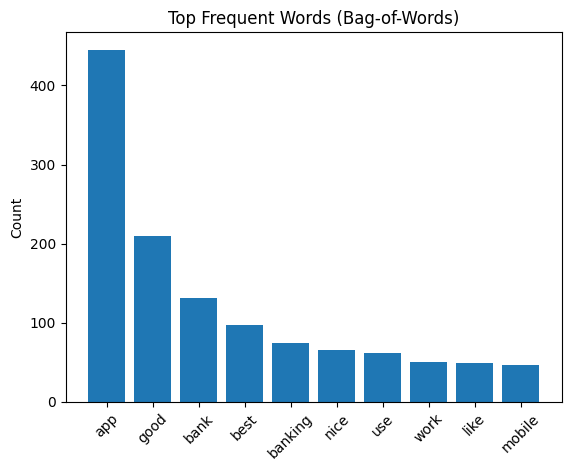

In [12]:
# Cell 8: Plot top frequent words (Frequency-Based)
import matplotlib.pyplot as plt

top_n = 10
top_freq = freq_df.head(top_n)

plt.bar(top_freq["word"], top_freq["count"])
plt.xticks(rotation=45)
plt.title("Top Frequent Words (Bag-of-Words)")
plt.ylabel("Count")
plt.show()


TF-IDF representation

In [14]:
# Cell 9: TF-IDF representation
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(stop_words="english")
X_tfidf = tfidf_vec.fit_transform(df["clean_text"])

# Get average TF-IDF score per word across documents
tfidf_means = np.asarray(X_tfidf.mean(axis=0)).flatten()
vocab_tfidf = np.array(tfidf_vec.get_feature_names_out())

tfidf_df = pd.DataFrame({"word": vocab_tfidf, "tfidf": tfidf_means})
tfidf_df = tfidf_df.sort_values("tfidf", ascending=False)
tfidf_df.head(10)


,word,tfidf
692,good,0.127537
123,app,0.075802
218,best,0.049449
1027,nice,0.041343
181,bank,0.024561
1628,wow,0.018177
552,excellent,0.016045
886,like,0.015710
702,great,0.015644
186,banking,0.014432


TF-IDF (Very Brief Explanation)

TF-IDF shows how important a word is in the dataset.

TF (Term Frequency): how often a word appears.

IDF (Inverse Document Frequency): how unique the word is across all reviews.

TF-IDF = TF × IDF

Higher TF-IDF = more meaningful word.
Lower TF-IDF = common or unimportant word.

✔ What is a good TF-IDF number?

No universal scale — it’s relative.
But generally in small datasets:

> 0.10 = very important

0.05–0.10 = meaningful

< 0.05 = low importance

 Interpretation of our output

“app” (0.1099) → highly important theme

“slow”, “crashing”, “frustrating” → key negative issues

“options”, “good”, “works” → meaningful topics in reviews

Compare TF-IDF vs raw frequency

In [15]:
# Cell 10: Compare top words by frequency and by TF-IDF

print("Top 10 by raw frequency:")
display(freq_df.head(10))

print("\nTop 10 by TF-IDF (words more unique / informative):")
display(tfidf_df.head(10))


Top 10 by raw frequency:


,word,count
123,app,445
692,good,210
181,bank,131
218,best,97
186,banking,75
1027,nice,65
1543,use,62
1620,work,50
886,like,49
982,mobile,47



Top 10 by TF-IDF (words more unique / informative):


,word,tfidf
692,good,0.127537
123,app,0.075802
218,best,0.049449
1027,nice,0.041343
181,bank,0.024561
1628,wow,0.018177
552,excellent,0.016045
886,like,0.015710
702,great,0.015644
186,banking,0.014432


Topic Modeling (LDA)


Rating distribution per bank:
rating_grade  Negative  Neutral  Positive
bank_code                                
BOA                112       37        82
CBE                 36       49        94
Dashen              55       41       124


<Figure size 800x500 with 0 Axes>

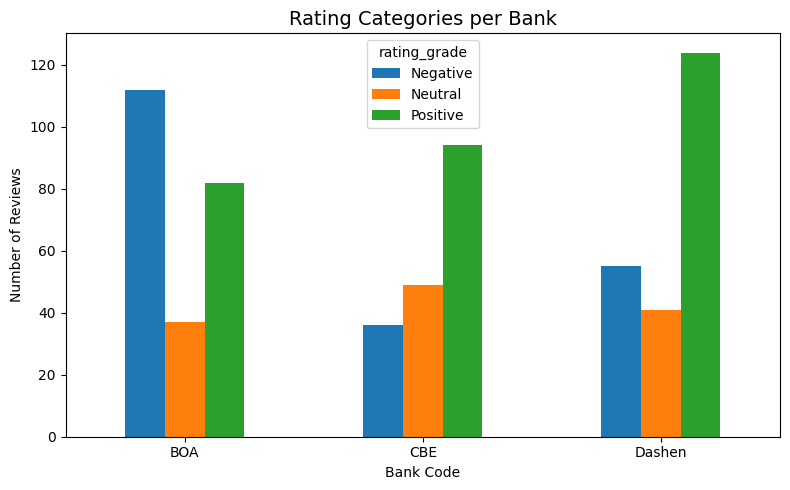

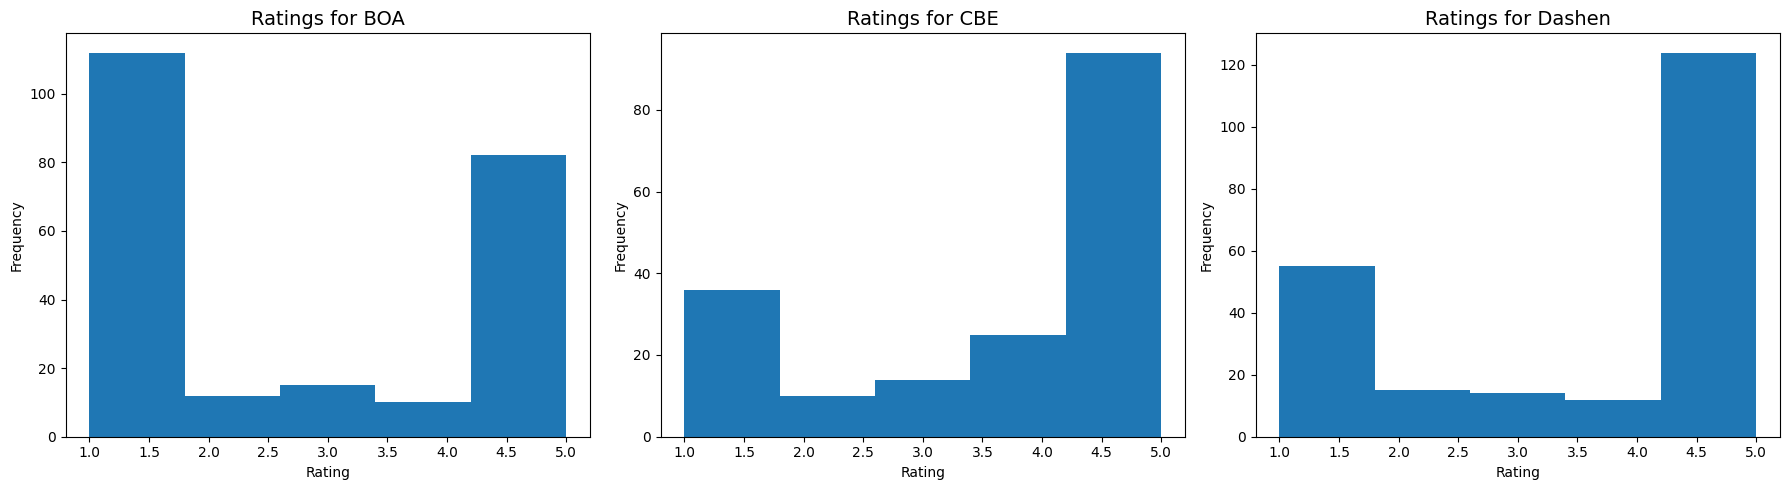

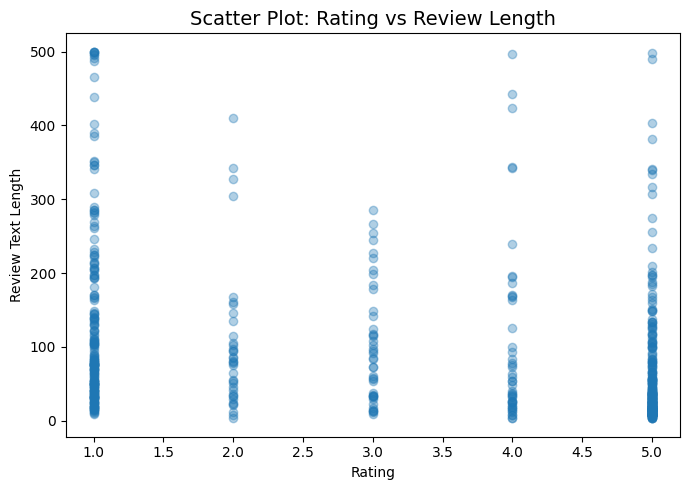

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 1. Load data
# ---------------------------
df = pd.read_csv("./Data/processed/cleaned_reviews.csv")

# ---------------------------
# 2. Grade numeric rating
# ---------------------------
def grade_rating(r):
    if r > 4:
        return "Positive"
    elif r == 4:
        return "Neutral"
    elif r < 2:
        return "Negative"
    else:
        return "Neutral"  # default for rating=2 or 3

df["rating_grade"] = df["rating"].apply(grade_rating)

# ---------------------------
# 3. Count per bank
# ---------------------------
rating_per_bank = df.groupby(["bank_code", "rating_grade"]).size().unstack(fill_value=0)

print("\nRating distribution per bank:")
print(rating_per_bank)

# ============================================================
# 4. VISUALIZATIONS
# ============================================================

# ---------------------------
# BAR GRAPH (per bank)
# ---------------------------
plt.figure(figsize=(8, 5))
rating_per_bank.plot(kind="bar", figsize=(8, 5))

plt.title("Rating Categories per Bank", fontsize=14)
plt.ylabel("Number of Reviews")
plt.xlabel("Bank Code")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ---------------------------
# HISTOGRAMS PER BANK
# ---------------------------

# Get list of banks
banks = df["bank_code"].unique()
banks = sorted(banks)  # optional order: ['BOA', 'CBE', 'DASHENBANK']

# Number of banks
n_banks = len(banks)

plt.figure(figsize=(6 * n_banks, 5))

for i, bank in enumerate(banks, 1):
    bank_df = df[df["bank_code"] == bank]

    plt.subplot(1, n_banks, i)
    plt.hist(bank_df["rating"], bins=5)
    plt.title(f"Ratings for {bank}", fontsize=14)
    plt.xlabel("Rating")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# ---------------------------
# SCATTER PLOT (rating vs review length)
# ---------------------------
df["review_length"] = df["review_text"].astype(str).apply(len)

plt.figure(figsize=(7, 5))
plt.scatter(df["rating"], df["review_length"], alpha=0.35)

plt.title("Scatter Plot: Rating vs Review Length", fontsize=14)
plt.xlabel("Rating")
plt.ylabel("Review Text Length")
plt.tight_layout()
plt.show()



Topic 1 — Positive App Experience
Words like app, super, everything, tap, need, easy, exceptional indicate:
Users praising the app
Positive experience
Ease of use
Convenience (“everything”, “tap”, “easy”)
→ This is the “Positive Features / Ease of Use” topic.
Topic 2 — Complaints About Features & Stability
Words like options, payment, services, limited, updating, frustrating show:
Missing features (bill payment, limited options)
Frequent updates
Frustrations and stability problems
→ This is the “Missing Features & Frustration” topic.

Part-of-Speech Tagging (Noun Extraction)

2 – Lexicon-Based Sentiment (TextBlob & VADER)

TextBlob sentiment

In [38]:
# Cell 11: Lexicon-based sentiment with TextBlob
# Polarity in [-1, 1], subjectivity in [0, 1]

# Get polarity and subjectivity
from textblob import TextBlob
df["tb_polarity"] = df["review_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["tb_subjectivity"] = df["review_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Convert polarity → sentiment label
def polarity_to_label(p):
    if p > 0.1:
        return "positive"
    elif p < -0.1:
        return "negative"
    else:
        return "neutral"

df["tb_sentiment"] = df["tb_polarity"].apply(polarity_to_label)

# Show output
df[["review_text", "rating", "tb_polarity", "tb_subjectivity", "tb_sentiment"]]


,review_text,rating,tb_polarity,tb_subjectivity,tb_sentiment
0,bad exprience...it is so crushed,1,-0.400000,0.383333,negative
1,not user friendly at all it requires a huge co...,1,0.425000,0.633333,positive
2,most of the time is not working properly,1,0.250000,0.300000,positive
3,It keeps notifying me to disable developer opt...,1,0.068182,0.393939,neutral
4,the lag is unbelievable when you need it the m...,1,0.125000,0.750000,positive
...,...,...,...,...,...
625,"To be honest, best banking and lifestyle app i...",5,0.800000,0.600000,positive
626,"A must have, seamless, all in one digital plat...",5,0.050000,0.050000,neutral
627,Amazing app super easy to use and best design....,5,0.613333,0.700000,positive
628,its the best ever,5,1.000000,0.300000,positive


VADER sentiment

In [41]:
# Cell 12: Lexicon-based sentiment with VADER
# VADER is optimized for reviews, slang, emojis, and short texts
from nltk.sentiment import SentimentIntensityAnalyzer
def vader_compound(text):
    sia = SentimentIntensityAnalyzer()

    return sia.polarity_scores(text)["compound"]


# VADER compound score
df["vader_compound"] = df["review_text"].apply(vader_compound)

# Convert compound score → sentiment label
# Standard VADER rule:
# compound >= 0.05 → positive
# compound <= -0.05 → negative
# otherwise → neutral

def vader_label(c):
    if c >= 0.05:
        return "positive"
    elif c <= -0.05:
        return "negative"
    else:
        return "neutral"

df["vader_sentiment"] = df["vader_compound"].apply(vader_label)

# Show output
df[["review_text", "rating", "tb_polarity", "vader_compound", "vader_sentiment"]]


,review_text,rating,tb_polarity,vader_compound,vader_sentiment
0,bad exprience...it is so crushed,1,-0.400000,-0.7973,negative
1,not user friendly at all it requires a huge co...,1,0.425000,-0.4268,negative
2,most of the time is not working properly,1,0.250000,0.0000,neutral
3,It keeps notifying me to disable developer opt...,1,0.068182,-0.4019,negative
4,the lag is unbelievable when you need it the m...,1,0.125000,-0.1531,negative
...,...,...,...,...,...
625,"To be honest, best banking and lifestyle app i...",5,0.800000,0.8176,positive
626,"A must have, seamless, all in one digital plat...",5,0.050000,0.0000,neutral
627,Amazing app super easy to use and best design....,5,0.613333,0.9623,positive
628,its the best ever,5,1.000000,0.6369,positive


visualization of lexicon scores vs rating

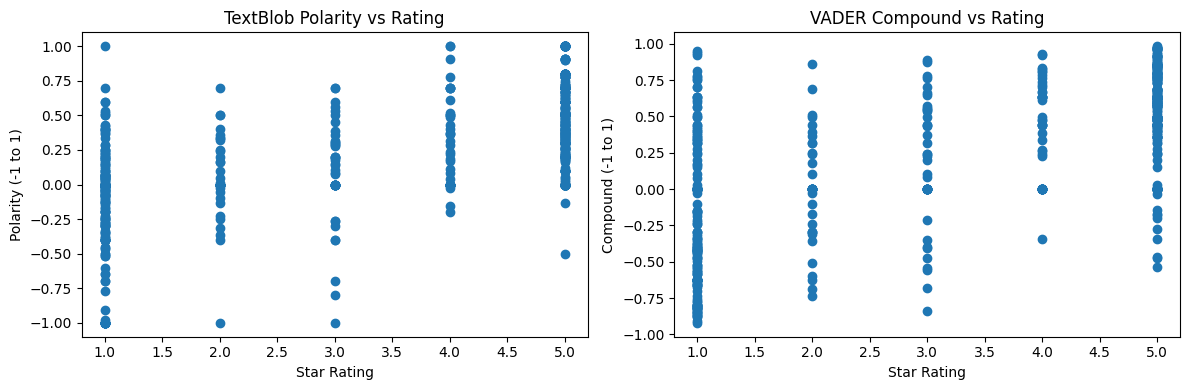

In [42]:
# Cell 13: See how lexicon scores correlate with star rating

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(df["rating"], df["tb_polarity"])
axes[0].set_title("TextBlob Polarity vs Rating")
axes[0].set_xlabel("Star Rating")
axes[0].set_ylabel("Polarity (-1 to 1)")

axes[1].scatter(df["rating"], df["vader_compound"])
axes[1].set_title("VADER Compound vs Rating")
axes[1].set_xlabel("Star Rating")
axes[1].set_ylabel("Compound (-1 to 1)")

plt.tight_layout()
plt.show()



=========== BANK: BOA ===========


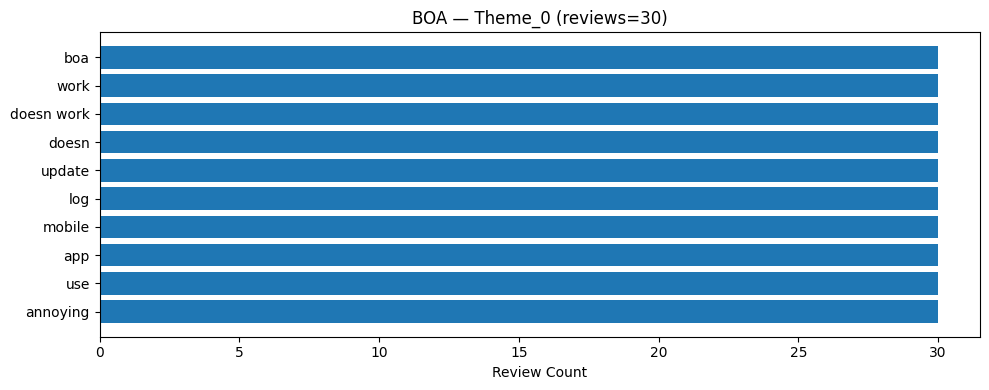

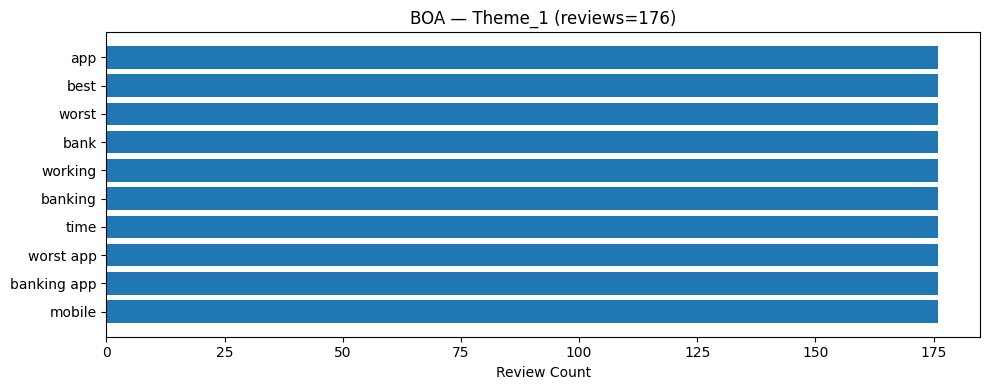

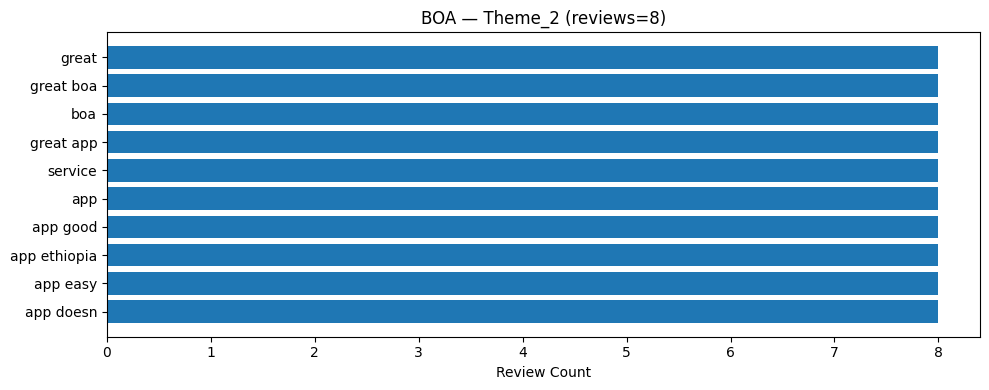

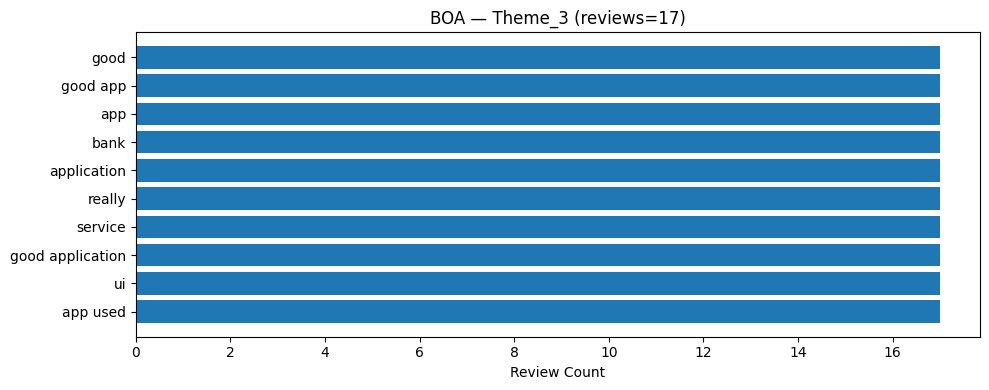


=========== BANK: CBE ===========


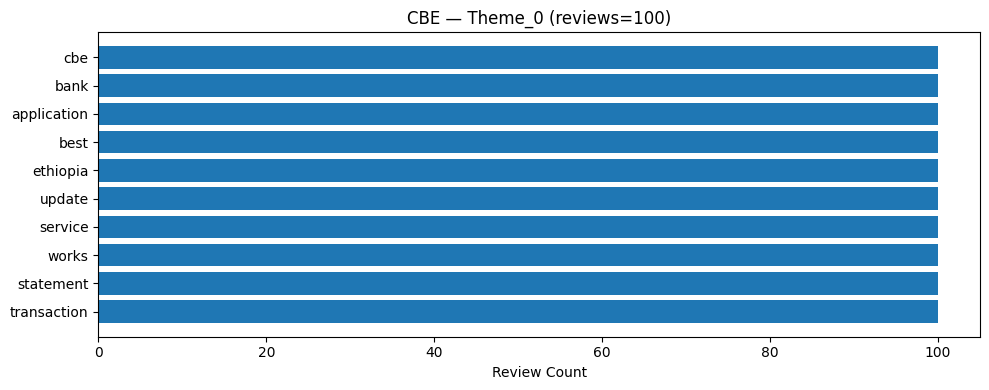

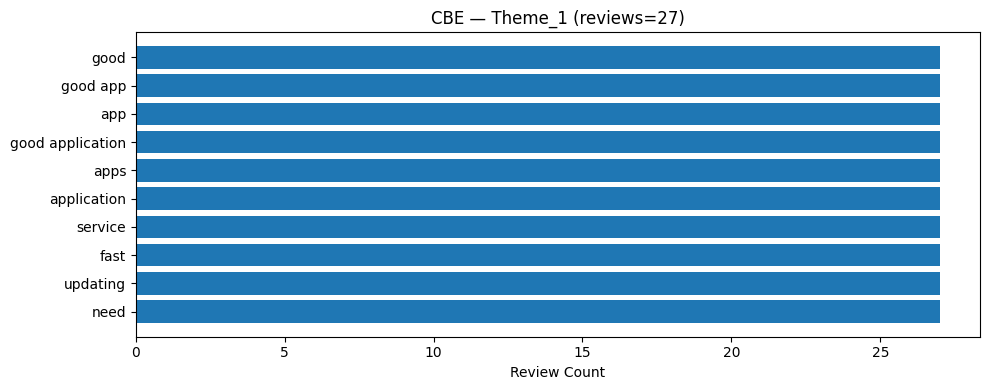

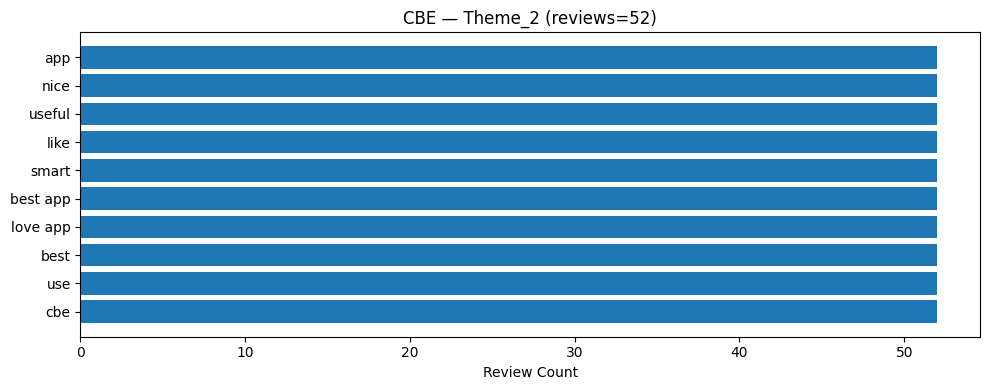


=========== BANK: Dashen ===========


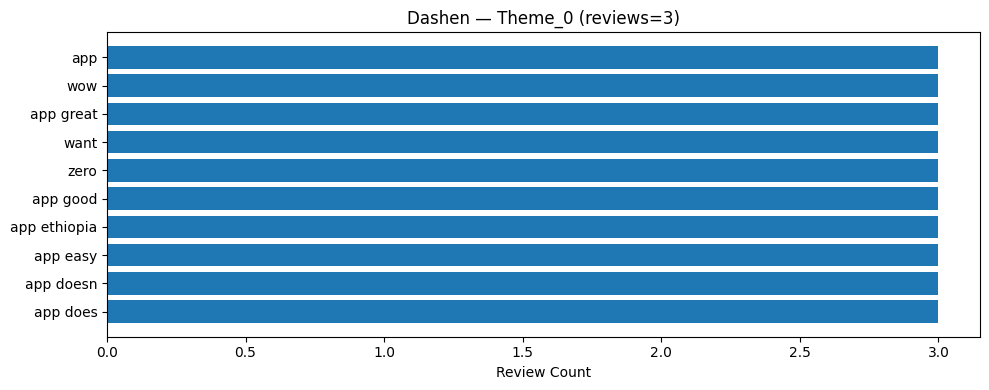

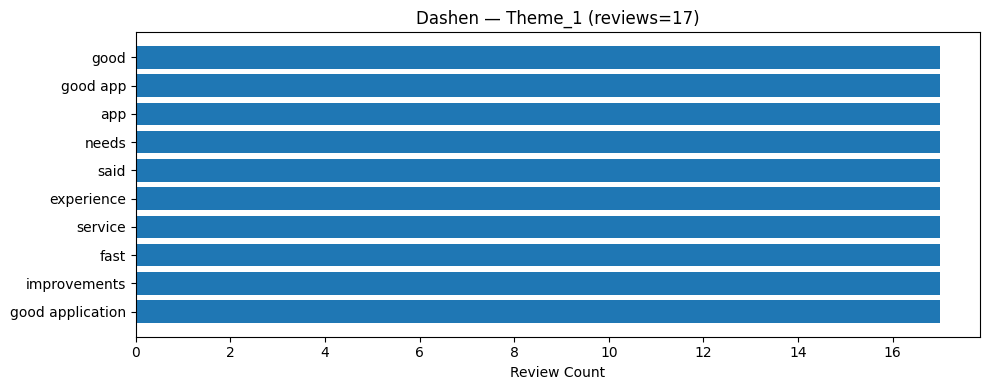

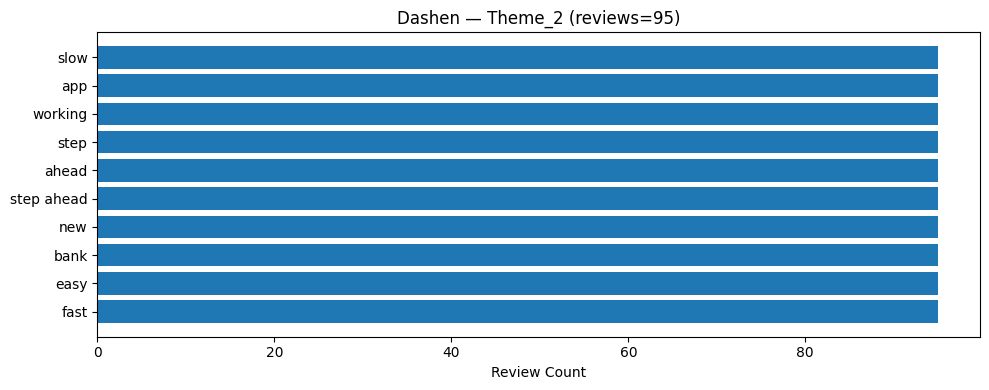

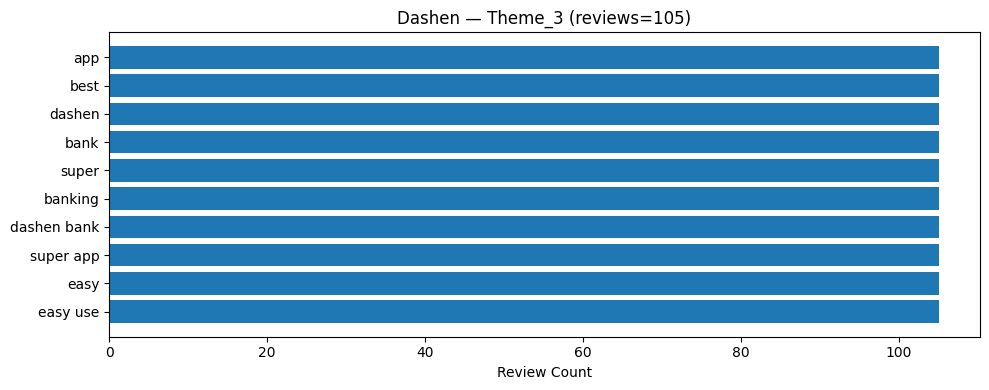

In [45]:
# =========================================================
# 1. IMPORTS
# =========================================================
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt


# =========================================================
# 2. LOAD DATA
# =========================================================
df = pd.read_csv("./data/processed/cleaned_reviews.csv")

required_cols = ["review_text", "bank_code"]
for col in required_cols:
    assert col in df.columns, f"Missing column: {col}"

df["review_text"] = df["review_text"].fillna("")


# =========================================================
# 3. TEXT CLEANING (FAST)
# =========================================================
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df["cleaned_text"] = df["review_text"].apply(clean_text)


# =========================================================
# 4. TF-IDF (OPTIMIZED)
# =========================================================
vectorizer = TfidfVectorizer(
    max_features=7000,       # more features → better keywords
    min_df=3,                # ignore rare words
    stop_words="english",
    ngram_range=(1, 2)
)

tfidf_matrix = vectorizer.fit_transform(df["cleaned_text"])
tfidf_matrix = normalize(tfidf_matrix)   # boosts clustering quality
feature_names = vectorizer.get_feature_names_out()


# =========================================================
# 5. THEMATIC CLUSTERING PER BANK (OPTIMIZED)
# =========================================================
df["theme"] = -1
unique_banks = df["bank_code"].unique()

for bank in unique_banks:
    bank_mask = df["bank_code"] == bank
    bank_matrix = tfidf_matrix[bank_mask.values]

    n_reviews = bank_matrix.shape[0]
    n_themes = min(5, max(1, n_reviews // 50))   # auto-tuned by dataset size

    if n_reviews < 10:
        df.loc[bank_mask, "theme"] = 0
        continue

    model = MiniBatchKMeans(
        n_clusters=n_themes,
        batch_size=256,
        random_state=42,
        n_init="auto"
    )

    labels = model.fit_predict(bank_matrix)
    df.loc[bank_mask, "theme"] = labels


# =========================================================
# 6. TOP KEYWORDS PER THEME (GLOBAL)
# =========================================================
def extract_theme_keywords(tfidf_matrix, df, feature_names, n_terms=10):
    results = {}

    for theme in sorted(df["theme"].unique()):
        mask = (df["theme"] == theme)
        theme_matrix = tfidf_matrix[mask.values]

        if theme_matrix.shape[0] == 0:
            results[f"Theme_{theme}"] = []
            continue

        avg_vec = theme_matrix.mean(axis=0).A1
        top_ids = avg_vec.argsort()[-n_terms:][::-1]

        results[f"Theme_{theme}"] = feature_names[top_ids].tolist()

    return results

theme_keywords = extract_theme_keywords(tfidf_matrix, df, feature_names)
theme_keywords


# =========================================================
# 7. TOP KEYWORDS PER BANK PER THEME
# =========================================================
def extract_keywords_bank_theme(df, tfidf_matrix, feature_names, n_terms=10):
    result = {}
    for bank in df["bank_code"].unique():
        result[bank] = {}
        bank_df = df[df["bank_code"] == bank]

        for theme in sorted(bank_df["theme"].unique()):
            mask = (df["bank_code"] == bank) & (df["theme"] == theme)
            theme_matrix = tfidf_matrix[mask.values]

            if theme_matrix.shape[0] == 0:
                result[bank][f"Theme_{theme}"] = []
                continue

            avg_vec = theme_matrix.mean(axis=0).A1
            top_ids = avg_vec.argsort()[-n_terms:][::-1]

            result[bank][f"Theme_{theme}"] = feature_names[top_ids].tolist()

    return result

bank_theme_keywords = extract_keywords_bank_theme(df, tfidf_matrix, feature_names)
bank_theme_keywords


# =========================================================
# 8. PLOT KEYWORDS BY BANK & THEME
# =========================================================
def plot_keyword_bars(bank_theme_keywords, df):
    for bank, themes in bank_theme_keywords.items():
        print(f"\n=========== BANK: {bank} ===========")

        for theme_name, keywords in themes.items():
            if len(keywords) == 0:
                continue

            theme_num = int(theme_name.split("_")[1])
            count = df[(df["bank_code"] == bank) & (df["theme"] == theme_num)].shape[0]

            plt.figure(figsize=(10, 4))
            plt.barh(keywords, [count] * len(keywords))
            plt.gca().invert_yaxis()
            plt.title(f"{bank} — {theme_name} (reviews={count})")
            plt.xlabel("Review Count")
            plt.tight_layout()
            plt.show()


plot_keyword_bars(bank_theme_keywords, df)